In [1]:
from ChemBERT_module import ChemBERT, combinatorial_synthesis
from ReactionT5Yield_module import ReactionT5Yield, predict_yield
from ReactionT5Retrosynthesis_module import ReactionT5Retrosynthesis, retrosynthesis
from output_visualization import visualize_output

import pandas as pd
from supervised import AutoML
import os
from mordred import Calculator, descriptors
from tqdm.notebook import tqdm
import IPython

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.QED import default
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
model_path  = r"C:\Users\adamm\Desktop\BigStreamlitApp\5ht6_fixed_pKi"
model = AutoML(results_path=model_path)
sm = 'c1cc(F)ccc1CO'

In [3]:
l1, l2 = combinatorial_synthesis(sm, iterations=200, max_new_tokens=40)

  0%|          | 0/200 [00:00<?, ?it/s]

In [4]:
l1.insert(0, Chem.MolFromSmiles(sm))
l2.insert(0, sm)

In [5]:
df = pd.DataFrame(data = l1, columns = ['Mols'])
df['Mols'] = df['Mols'].apply(lambda x: Chem.AddHs(x))

In [6]:
def generate_3d_coordinates(molecule):
    if molecule is None:
        return None

    status = AllChem.EmbedMolecule(molecule, randomSeed=42)
    if status != 0:
        return None

    AllChem.MMFFOptimizeMolecule(molecule)
    return molecule

In [7]:
d = []
calc = Calculator(descriptors, ignore_3D=False)

for mol in tqdm(df['Mols'], desc="Calculating descriptors"):
    m = generate_3d_coordinates(mol)
    if m is not None:
        d.append(calc(m))

Calculating descriptors:   0%|          | 0/167 [00:00<?, ?it/s]

In [8]:
#df with descriptors calculated for combinatorial library compounds
df_descriptors = pd.DataFrame(d, columns = [str(name) for name in calc.descriptors])
df_descriptors = df_descriptors.select_dtypes('number')

In [9]:
#df with descriptors calculated for compounds used for AutoML training (important to extract the same descriptors)
df_descriptors_pattern = pd.read_csv(r'C:\Users\adamm\BigStreamlitApp\df_descriptors_fixed_pKi.csv')
df_descriptors_pattern = df_descriptors_pattern.select_dtypes('number')
cols = df_descriptors_pattern.columns[2:]

#matching the same descriptors
df_descriptors = df_descriptors[cols]

C:\Users\adamm\AppData\Local\Temp\ipykernel_7024\1088268098.py:2: DtypeWarning: Columns (144,145,153,154,162,163,171,172,180,181,189,190,198,199,207,208,216,217,225,226,234,235,236,237,238,239,240,241,242,243,244,344,345,346,347,348,349,350,351,352,360,361,369,370,378,379,387,388,396,397,405,406,414,415,423,424,432,433,441,442,450,451,452,453,454,455,456,457,458,459,466,467,474,475,482,483,490,491,498,499,506,507,514,515,522,523,530,531,538,539,546,547,548,549,550,551,552,553,554,555,562,563,570,571,578,579,586,587,594,595,602,603,610,611,618,619,626,627,634,635,642,643,644,645,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,877,885,1104,1109,1183,1188,1578,1798) have mixed types. Specify dtype option on import or set low_memory=False.


In [10]:
#pKi predicting
results = model.predict(df_descriptors)

In [11]:
df_results1 = pd.DataFrame(data = l2, columns=['smiles'])                               #df with smiles of combinatorial library compounds
df_results2 = pd.DataFrame(data = pd.Series(results), columns=['Predicted_pKi'])        #df with pKi predictions
df_results3 = pd.DataFrame(data = l1, columns=['mols'])                                 #df with Mols of combinatorial library compounds

df_results_final = pd.concat([df_results1, df_results2, df_results3], axis = 1)
df_results_final['name'] = [f'Molecule {idx}' for idx in range(df_results_final.shape[0])] 
df_results_final['qed'] = df_results_final['mols'].apply(lambda x: default(x))
df_results_final['substrates'] = df_results_final['smiles'].apply(lambda x: retrosynthesis(x))
df_results_final['yield'] = [predict_yield(substrat, product) for substrat, product in zip(df_results_final['substrates'], df_results_final['smiles'])]

df_results_final = df_results_final.sort_values(by = 'Predicted_pKi', ascending=False) 

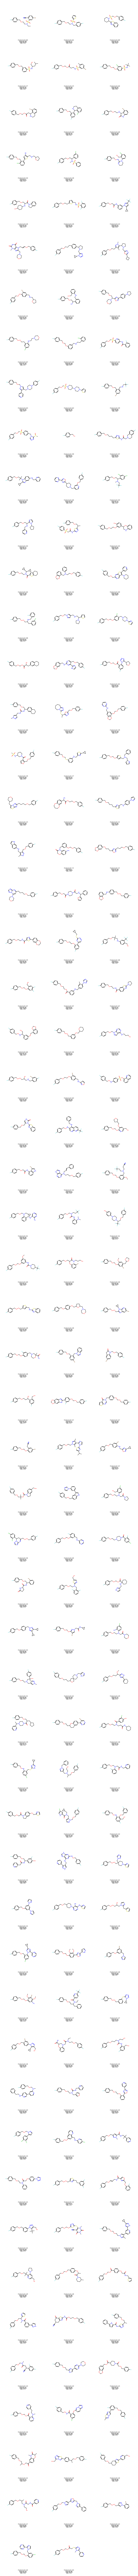

In [12]:
visualize_output(df_results_final, molsPerRow=3, maxMols=df_results_final.shape[0])